# Summarize Group Performance 
---------------------
- Desc: Summary statistics for task performance in EEG study
- Author:  G.FragaGonzalez & S. Mueller



## Read data

In [40]:
#  Set up 
# ------------------------------------------------------------------
from datetime import date
today = date.today()
print("Today's date:", today)
import sys
import os
import glob
import re
import pandas as pd
import numpy as np
import plotly.express as px 

# If plotly not install do so in the Anaconda prompt with: 
#conda install -c plotly plotly 
#conda install -c conda-forge itables
from itables import init_notebook_mode, show 

# FILE PATHS 
# -------------------------------------------------------
thisScriptDir = os.getcwd()
baseDir = thisScriptDir[:thisScriptDir.find("Scripts")]
dirinput = os.path.join(baseDir + 'Data','SiN','analysis','beh','task-sin')
diroutput = os.path.join(baseDir + 'Data','SiN','analysis','beh','task-sin')

# Find file read data set 
# --------------------------------------------------------------------------------------------
fileinput =  [os.path.join(dirinput, f) for f in os.listdir(dirinput) if f.startswith('Gathered_')]
df = pd.read_csv(fileinput[0], index_col=None)

# Display 
#show(df,column_filters="footer", dom="lrtip",scrollY="300px", scrollCollapse=False,paging=False)

# Add recoded variables for interpretability
#-----------------------------------------------------------
# Relabel noise levels
levelmapping = {
    '0.6p': '1_easy',    
    '0.4p': '2_mid',
    '0.2p': '3_hard',
    '-7db': '1_easy',
    '-9db': '2_mid',
    '-11db': '3_hard'        
    
}
df['level'] = df['levels'].replace(levelmapping)

    
# Relabel blocks
blockmapping = {
    'NV1': '1',
    'NV2': '2',
    'SSN1': '1',
    'SSN2': '2'       
}

df['block'] = df['block'].replace(blockmapping)




Today's date: 2023-12-01


## Transform to long format and Save

In [41]:
df_long= pd.melt(df, id_vars=['subj','noise','block','levels','level'], value_vars=['callSignCorrect', 'colourCorrect','numberCorrect'],value_name='accu')
#show(df_long,column_filters="footer", dom="lrtip",scrollY="300px", scrollCollapse=False,paging=False)
df_long.to_csv(os.path.join(diroutput + 'Gathered_long.csv'))
#os.path.join(diroutput, 'Gathered_long.csv')

## Descriptive Statistics

### Averaged across subjects and items 

In [42]:
init_notebook_mode(all_interactive=True)
df_grouped1 = df_long.groupby(['noise','block','level'])[['accu']].agg(['mean', 'std','sem'])
df_grouped1.columns = [f'{col[0]}_{col[1]}' for col in df_grouped1.columns]
df_grouped1 = df_grouped1.reset_index()
#show(df_grouped1, column_filters="footer", dom="lrtip",scrollY="300px", scrollCollapse=False,paging=False)

<IPython.core.display.Javascript object>

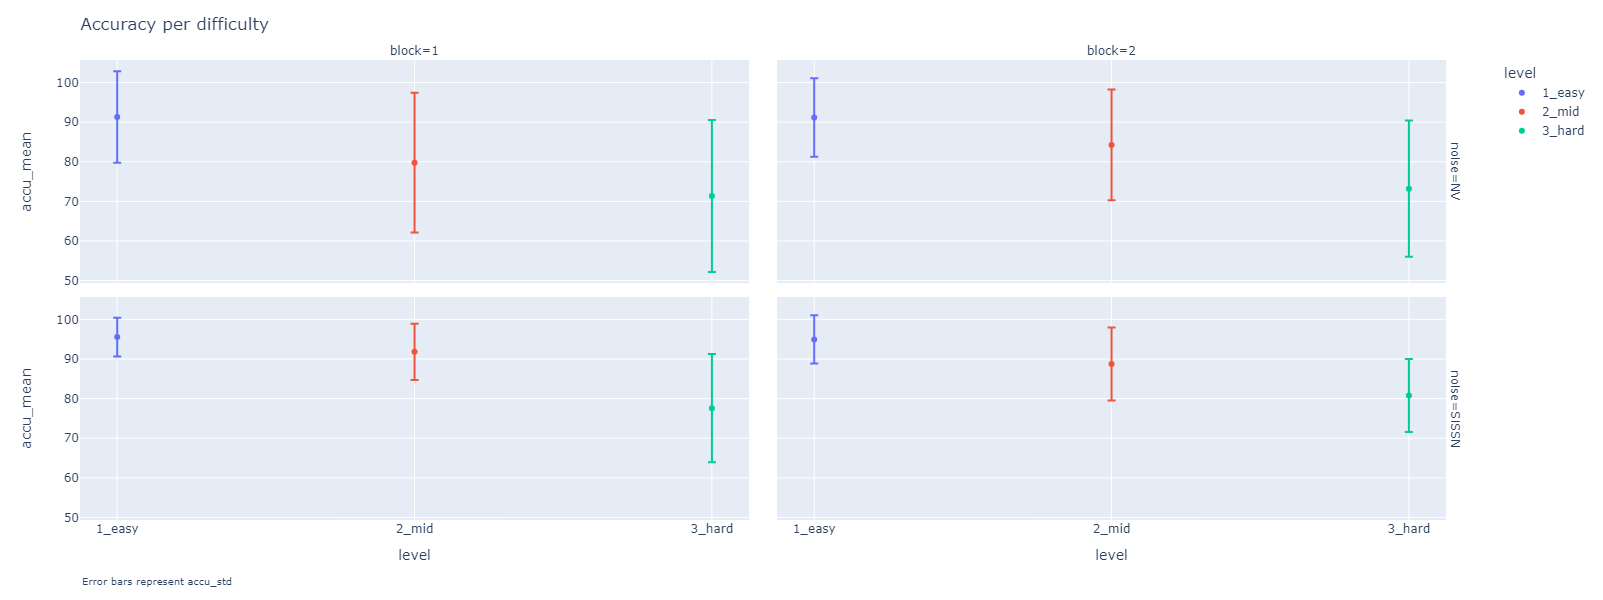

In [43]:

# Define error bars
ebars = "accu_std"
depvar = "accu_mean"
def create_scatter_plot(datain, title):
    # Create a scatter plot with error bars
    fig = px.scatter(
        datain, 
        x="level", 
        y=depvar, 
        color="level", 
        facet_col="block", 
        facet_row="noise",
        error_x=ebars, 
        error_y=ebars
    )

    # Update layout for larger figure and add title
    fig.update_layout(
        #xaxis_title='LV',
        yaxis_title=depvar,
        height=600,  # Set the height
        width=800,    # Set the width
        title=f'{title}'  # Add title
    )

    ## Add footnote
    fig.add_annotation(
        text="Error bars represent " + ebars,
        xref="paper", yref="paper",
        x=0, y=-0.15,
        showarrow=False,
        font=dict(size=10)
    )
    
    return fig


fig = create_scatter_plot(df_grouped1,'Accuracy per difficulty ')
fig.show()

# Filter data for Task A and create plot with title
#df_a = df_long[df_long['noise'] == 'NV']
#df_a['levels']
#fig_a = create_scatter_plot(df_a, 'NV')
#fig_a.show()

# Filter data for Task B and create plot with title
#df_b = df_long[df_long['noise'] == 'SiSSN']
#fig_b = create_scatter_plot(df_b, 'SiSSN')
#fig_b.show()




### Each subject averaged accross items

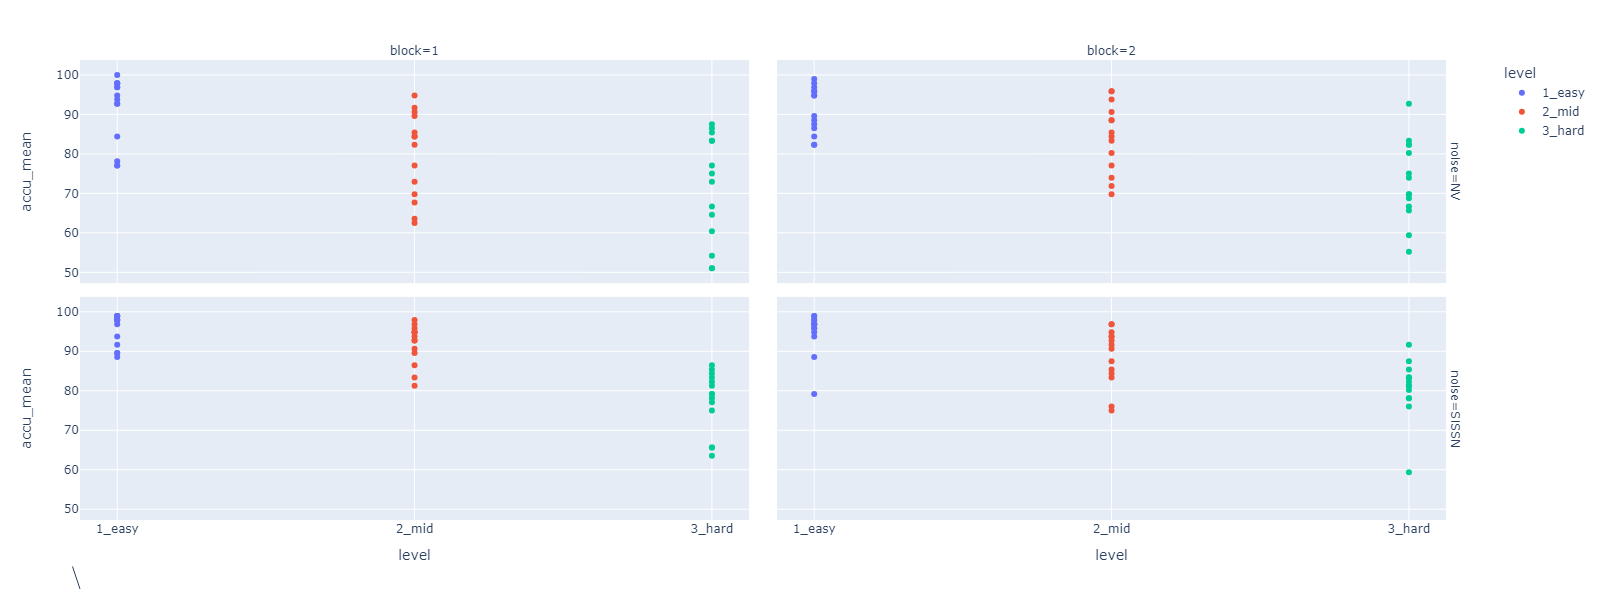

In [44]:
# combining only 
df_grouped2 = df_long.groupby(['subj','noise','block','level'])[['accu']].agg(['mean', 'std','sem'])
df_grouped2.columns = [f'{col[0]}_{col[1]}' for col in df_grouped2.columns]
df_grouped2 = df_grouped2.reset_index()




# Define error bars
depvar = "accu_mean"
def create_scatter_plot(datain, title):
    # Create a scatter plot with error bars
    fig = px.scatter(
        datain, 
        x="level", 
        y=depvar, 
        color="level", 
        facet_col="block", 
        facet_row="noise"        
    )

    # Update layout for larger figure and add title
    fig.update_layout(
        #xaxis_title='LV',
        yaxis_title=depvar,
        height=600,  # Set the height
        width=800    # Set the width        
    )

    ## Add footnote
    fig.add_annotation(        
        xref="paper", yref="paper",
        x=0, y=-0.15,
        showarrow=True,
        font=dict(size=10) 
        
    )
    
    return fig


fig = create_scatter_plot(df_grouped2,'Accuracy per difficulty')
fig.show() 


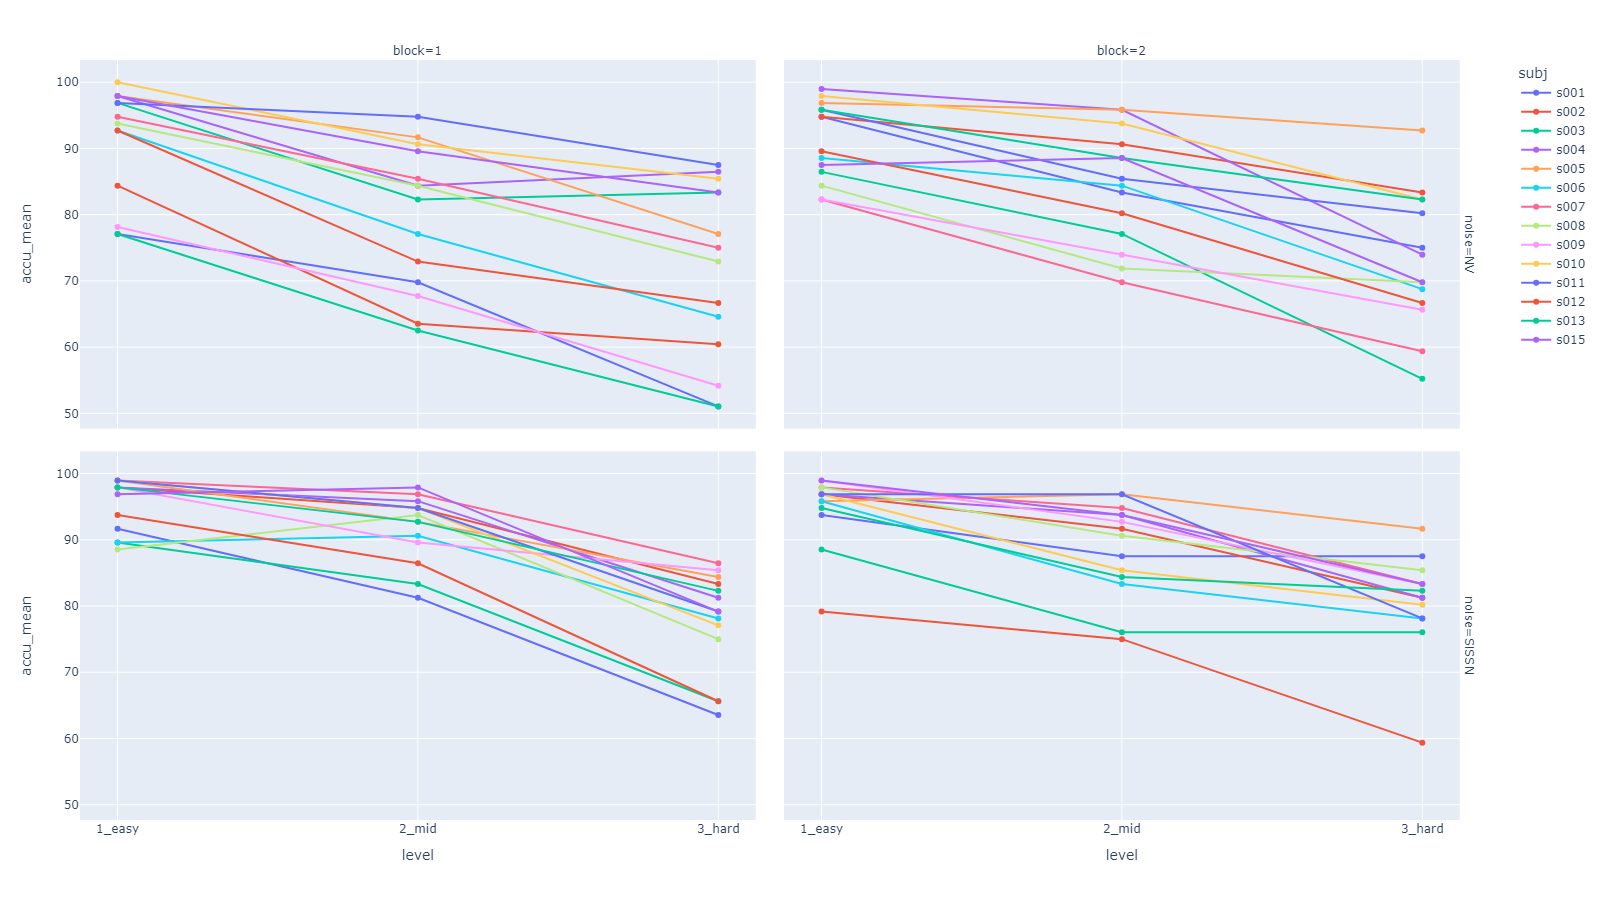

In [45]:
#import plotly.graph_objects as go

depvar = 'accu_mean'
fig = px.line(
    df_grouped2, 
    x="level", 
    y=depvar, 
    color="subj",
    markers=True,
    facet_col="block", 
    facet_row = "noise",
     width=900, height=900
)

#fig.data[0].update(mode='markers+lines')
fig.show()


## Linear mixed models

In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [ ]:

md = smf.mixedlm("accu ~ noise + level + block", df_long, groups = df_long["subj"]) 
mdf = md.fit()
print(mdf.summary())

#sm.stats.anova_lm(mdf, typ=2)


In [ ]:
#md = smf.mixedlm("accu_mean ~ noise * level * block", df_grouped2, groups = df_grouped2["subj"]) 
#print(mdf.summary())
#df_grouped2